# LIBRAIRIES IMPORTATION

In [1]:
import pandas as pd
import numpy as np
import datetime
import nbformat
import wordcloud

import seaborn as sns
pal = sns.color_palette()

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly import tools
import plotly.io as pio
import io
pio.renderers.default = "vscode"

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from IPython.display import display
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

 # FILES READING AND MISSING VALUES TREATMENT

In [2]:
# Import dataset
print("Loading dataset...")
df = pd.read_csv("./assets/flights_usa_2019.csv")  # sep = ";"
pd.set_option('display.max_columns', None)
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9351550 entries, 0 to 9351549
Data columns (total 33 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY_OF_MONTH         int64  
 2   DAY_OF_WEEK          int64  
 3   OP_UNIQUE_CARRIER    object 
 4   TAIL_NUM             object 
 5   OP_CARRIER_FL_NUM    int64  
 6   ORIGIN_AIRPORT_ID    int64  
 7   ORIGIN               object 
 8   ORIGIN_CITY_NAME     object 
 9   DEST_AIRPORT_ID      int64  
 10  DEST                 object 
 11  DEST_CITY_NAME       object 
 12  CRS_DEP_TIME         int64  
 13  DEP_TIME             float64
 14  DEP_DELAY_NEW        float64
 15  DEP_DEL15            float64
 16  DEP_TIME_BLK         object 
 17  CRS_ARR_TIME         int64  
 18  ARR_TIME             float64
 19  ARR_DELAY_NEW        float64
 20  ARR_TIME_BLK         object 
 21  CANCELLED            float64
 22  CANCELLATION_CODE    object 
 23  CRS_ELAPSED_TIME     float64
 24

In [4]:
#  Merge airports list into dataframe

airports = pd.read_csv('./assets/airports_list.csv')
airports.head(1)

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"


In [5]:
df = pd.merge(df, airports[['ORIGIN_AIRPORT_ID','NAME']], left_on='ORIGIN_AIRPORT_ID', right_on='ORIGIN_AIRPORT_ID')
df.head(1)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


In [6]:
# Merge carriers list into dataframe
carriers = pd.read_csv('./assets/CARRIER_DECODE.csv')
carriers.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
df = pd.merge(df, carriers, on='OP_UNIQUE_CARRIER', how='left')

df.head(1)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,NAME,AIRLINE_ID,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,20363,Endeavor Air Inc.


In [7]:
df = df.drop([ 'Unnamed: 32', 'AIRLINE_ID'], axis=1)
df = df.rename(columns={'NAME': 'ORIGIN_AIRPORT_NAME'})

df.head(1)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.


In [8]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head(1))
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")

pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})


Number of rows : 8467550

Display of dataset: 


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.



Basics statistics: 


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
count,8.467550e+06,8.467550e+06,8.467550e+06,8467550,8447243,8.467550e+06,8.467550e+06,8467550,8467550,8.467550e+06,8467550,8467550,8.467550e+06,8.319657e+06,8.319642e+06,8.319642e+06,8467550,8.467550e+06,8.310735e+06,8.291538e+06,8467550,8.467550e+06,153885,8.467458e+06,8.291538e+06,8.467550e+06,8.467550e+06,1.612989e+06,1.612989e+06,1.612989e+06,1.612989e+06,1.612989e+06,8467550,8467550
unique,NaN,NaN,NaN,17,5884,NaN,NaN,97,93,NaN,352,344,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,19,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86,17
top,NaN,NaN,NaN,WN,N485HA,NaN,NaN,ATL,"Chicago, IL",NaN,ATL,"Chicago, IL",NaN,NaN,NaN,NaN,0800-0859,NaN,NaN,NaN,2100-2159,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",Southwest Airlines Co.
freq,NaN,NaN,NaN,1686918,4124,NaN,NaN,498732,533869,NaN,378776,445778,NaN,NaN,NaN,NaN,583123,NaN,NaN,NaN,559544,NaN,78135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533869,1686918
mean,6.534821e+00,1.575653e+01,3.917954e+00,NaN,NaN,2.439554e+03,1.266348e+04,NaN,NaN,1.269319e+04,NaN,NaN,1.345101e+03,1.348418e+03,1.430791e+01,1.917129e-01,NaN,1.497401e+03,1.470709e+03,1.430017e+01,NaN,1.817350e-02,NaN,1.458664e+02,1.405224e+02,8.352383e+02,3.812627e+00,2.091995e+01,3.645534e+00,1.669074e+01,9.154433e-02,2.713975e+01,NaN,NaN
std,3.128598e+00,8.774243e+00,1.995189e+00,NaN,NaN,1.758195e+03,1.517638e+03,NaN,NaN,1.522350e+03,NaN,NaN,4.948391e+02,5.100432e+02,4.715889e+01,3.936485e-01,NaN,5.265462e+02,5.499145e+02,4.689079e+01,NaN,1.335785e-01,NaN,7.386748e+01,7.412633e+01,6.048638e+02,2.377937e+00,6.325475e+01,3.049884e+01,3.999751e+01,3.316565e+00,5.244635e+01,NaN,NaN
min,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,1.000000e+00,1.014000e+04,NaN,NaN,1.013500e+04,NaN,NaN,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,1.000000e+00,2.500000e+01,6.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
25%,4.000000e+00,8.000000e+00,2.000000e+00,NaN,NaN,9.690000e+02,1.129200e+04,NaN,NaN,1.129200e+04,NaN,NaN,9.200000e+02,9.220000e+02,0.000000e+00,0.000000e+00,NaN,1.106000e+03,1.051000e+03,0.000000e+00,NaN,0.000000e+00,NaN,9.100000e+01,8.600000e+01,3.950000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
50%,7.000000e+00,1.600000e+01,4.000000e+00,NaN,NaN,2.045000e+03,1.288900e+04,NaN,NaN,1.288900e+04,NaN,NaN,1.331000e+03,1.336000e+03,0.000000e+00,0.000000e+00,NaN,1.525000e+03,1.510000e+03,0.000000e+00,NaN,0.000000e+00,NaN,1.280000e+02,1.220000e+02,6.720000e+02,3.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,NaN,NaN
75%,9.000000e+00,2.300000e+01,6.000000e+00,NaN,NaN,3.678000e+03,1.393100e+04,NaN,NaN,1.405700e+04,NaN,NaN,1.749000e+03,1.756000e+03,7.000000e+00,0.000000e+00,NaN,1.931000e+03,1.926000e+03,8.000000e+00,NaN,0.000000e+00,NaN,1.750000e+02,1.720000e+02,1.068000e+03,5.000000e+00,1.800000e+01,0.000000e+00,2.000000e+01,0.000000e+00,3.300000e+01,NaN,NaN



Percentage of missing values: 


,Missing Records,Percentage (%)
MONTH,0,0.000000
DAY_OF_MONTH,0,0.000000
DAY_OF_WEEK,0,0.000000
OP_UNIQUE_CARRIER,0,0.000000
TAIL_NUM,20307,0.239821
OP_CARRIER_FL_NUM,0,0.000000
ORIGIN_AIRPORT_ID,0,0.000000
ORIGIN,0,0.000000
ORIGIN_CITY_NAME,0,0.000000
DEST_AIRPORT_ID,0,0.000000


In [9]:
# Remplacer les valeurs manquantes

print("Treatment of missing values... ")
cols_to_drop = ['CANCELLATION_CODE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
df = df.drop(cols_to_drop, axis=1)

to_median = ['DEP_DELAY_NEW', 'DEP_TIME', 'DEP_DEL15', 'ARR_TIME', 'ARR_DELAY_NEW', 'ACTUAL_ELAPSED_TIME', 'CRS_ELAPSED_TIME']
df[to_median] = df[to_median].fillna(df[to_median].mean())


print('Done')
print()
print("Percentage of missing values of treatment: ")
pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Treatment of missing values... 
Done

Percentage of missing values of treatment: 


,Missing Records,Percentage (%)
MONTH,0,0.000000
DAY_OF_MONTH,0,0.000000
DAY_OF_WEEK,0,0.000000
OP_UNIQUE_CARRIER,0,0.000000
TAIL_NUM,20307,0.239821
OP_CARRIER_FL_NUM,0,0.000000
ORIGIN_AIRPORT_ID,0,0.000000
ORIGIN,0,0.000000
ORIGIN_CITY_NAME,0,0.000000
DEST_AIRPORT_ID,0,0.000000


In [10]:
df.head(1)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,ORIGIN_AIRPORT_NAME,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,47.0,37.0,83.0,1,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.


# EDA 

In [11]:
# plotting departure airports for better visualization

# colors = sns.color_palette("colorblind", len(years))
colors = pal

df_airport = df['ORIGIN_AIRPORT_NAME'].value_counts()[:10]
label = df_airport.index
size = df_airport.values

trace = go.Pie(labels=label, values=size, marker=dict(colors=colors),hole = .2)

data = [trace]
layout = go.Layout(
    title='Flights Origin Airport'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

D'après le graphique ci-dessus, nous savons que l'aéroport international de Chicago O'Hare est le plus fréquenté en 2019, suivi de l'aéroport international d'Atlanta Hartsfield.

In [12]:
# plotting departure city

df_c = df.ORIGIN_CITY_NAME.value_counts()[:10]

trace = go.Bar(
    x=df_c.index,
    y=df_c.values,
    marker=dict(
        color = df_c.values,
        colorscale='Jet',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(
    title='Origin City Distribution', 
    yaxis = dict(title = 'Number of Flights')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

La barre de répartition ci-dessus montre que la plupart des vols partent de Chicago (plus 500 000 vols) et sont suivis par Atlanta.

In [13]:
df_airline = df.CARRIER_NAME.value_counts()[:10]

trace = go.Bar(
    x=df_airline.index,
    y=df_airline.values,
    marker=dict(
        color = df_airline.values,
        colorscale='Jet',
        showscale=True)
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=15),
    title='Airline distribution', 
                   yaxis = dict(title = 'Number of Flights'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

D'après le tableau ci-dessus, la compagnie aérienne la plus empruntée en 2019 est Southwest Airlines, suivi de American Airlines.

In [14]:
# Monthly flight traffic during the year

months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',6: 'Jun' , 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_m = df.MONTH.value_counts().to_frame().reset_index(names='index').sort_values(by='index')
df_m.columns = ['MONTH', 'FlightNum']
df_m.MONTHS = df_m.MONTH.map(months)

trace = go.Bar(
    x=df_m.MONTHS,
    y=df_m.FlightNum,
    marker=dict(
        color = df_m.FlightNum,
        colorscale='Reds',
        showscale=True)
)

data = [trace]
layout = go.Layout(
    title='Number of Flights (monthly)', 
    yaxis = dict(title = 'Number of Flights'
                                                )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

C:\Users\galus\AppData\Local\Temp\ipykernel_21088\848530057.py:6: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



La barre de distribution ci-dessus fournit des informations sur le nombre de vols par mois en 2019. Les plus élevés sont ceux de avril, juillet et aout. Par contre si nous comparons avec les autres mois, il n'y a pas de differnce de nombre de vols significative.

In [15]:
# Daily flight traffic during the year

days={1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
df_d = df.DAY_OF_WEEK.value_counts().to_frame().reset_index(names='index').sort_values(by='index')
df_d.columns = ['DAY_OF_WEEK', 'FlightNum']
df_d.DAY_OF_WEEK = df_d.DAY_OF_WEEK.map(days)

trace1 = go.Bar(
    x=df_d.DAY_OF_WEEK,
    y=df_d.FlightNum,
    marker=dict(
        color = df_d.FlightNum,  
        showscale=True
    )
)

data = [trace1]
layout = go.Layout(
    title='# of Flights (Day of Week)', 
    yaxis = dict(title = 'Number of Flights'
  )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le graphique ci-dessus, du lundi au vendredi, le nombre de vols est similaire et le plus bas est le samedi

In [16]:
# Percentage of delay per month

df['DEP_DELAY'] = np.where(df.DEP_DELAY_NEW>0,1,0)
df['ARR_DELAY'] = np.where(df.ARR_DELAY_NEW>0,1,0)
df_m = df.groupby('MONTH').DEP_DELAY_NEW.mean().round(2)

df_m.index = df_m.index.map(months)
trace1 = go.Bar(
    x=df_m.index,
    y=df_m.values,
    name = 'Departure_delay',
    marker = dict(
        color = 'green'
    )
)

df_m = df.groupby('MONTH').ARR_DELAY_NEW.mean().round(2)
df_m.index = df_m.index.map(months)

trace2 = go.Bar(
    x=df_m.index,
    y=df_m.values,
    name='Arrival_delay',
    marker=dict(
        color = 'red'
    )
)

data = [trace1,trace2]
layout = go.Layout(
    title='% Delay (Months)', 
    yaxis = dict(title = '%')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le tableau ci-dessus, le retard d'arrivée est supérieur à celui du retard de départ. On l'observe en juin oû on a enregistré le plus grand nombre de retard.

In [17]:
# Percentage of delay per month

df_d = df.groupby('DAY_OF_WEEK').DEP_DELAY_NEW.mean().round(2)
df_d.index = df_d.index.map(days)

trace1 = go.Bar(
    x=df_d.index,
    y=df_d.values,
    name = 'Departure_delay',
    marker=dict(
        color = 'cyan'
    )
)

df_d = df.groupby('DAY_OF_WEEK').ARR_DELAY_NEW.mean().round(2)
df_d.index = df_d.index.map(days)

trace2 = go.Bar(
    x=df_d.index,
    y=df_d.values,
    name='Arrival_delay',
    marker=dict(
        color = 'indigo'
    )
)

data = [trace1,trace2]
layout = go.Layout(
    title='% Delay (Day of Week)', 
    yaxis = dict(title = '%')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le graphique ci-dessus, la plupart des retards se sont produits le jeudi, le vendredi et le dimanche. Cependant, à la différence du mois où le nombre de retards d'arrivée est supérieur au retard de départ, lorsque nous comparons par jour de la semaine, le nombre de retards de départ est supérieur à celui du retard d'arrivée.

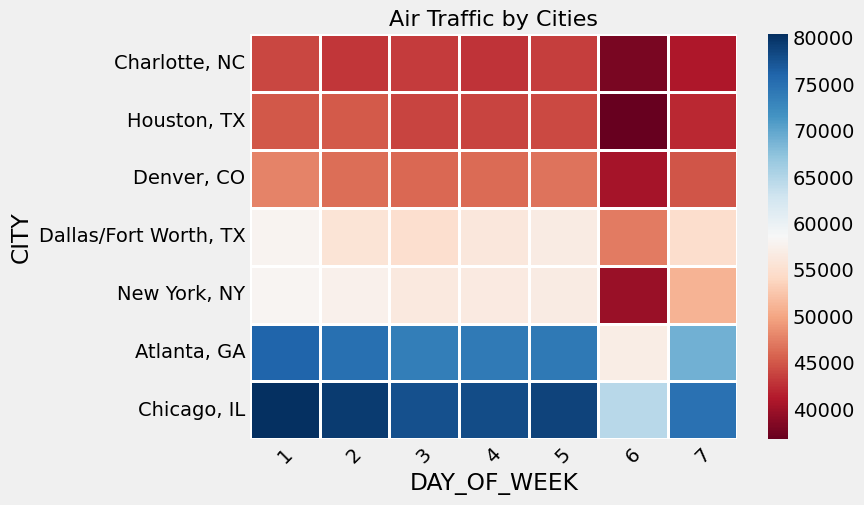

In [18]:
# Air traffic by city 

flight_volume = df.pivot_table(index="ORIGIN_CITY_NAME",columns="DAY_OF_WEEK",values="DAY_OF_MONTH",aggfunc=lambda x:x.count())
fv = flight_volume.sort_values(by=1, ascending=False)[:7]
fv = fv.iloc[::-1]

fig = plt.figure(figsize=(7, 5))
sns.heatmap(fv, cmap='RdBu',linecolor="w", linewidths=2)

plt.title('Air Traffic by Cities',size=16)
plt.ylabel('CITY')
plt.xticks(rotation=45)
plt.show()

D'après la carte ci-dessus, nous apprenons que samedi, de nombreuses personnes à Atlanta et à Chicago préfèrent ne pas quitter leur ville. Différent des autres villes où la plupart de leurs habitants choisissent de partir le samedi.

In [19]:
# Airlines comparison

df_a = df.groupby('CARRIER_NAME').DEP_DELAY_NEW.mean().to_frame().sort_values(by='DEP_DELAY_NEW', ascending=False).round(2)
trace1 = go.Bar(
    x=df_a.index,
    y=df_a.DEP_DELAY_NEW,
    name='Departure_delay',
    marker=dict(
        color = 'yellow'
    )
)

df_a = df.groupby('CARRIER_NAME').ARR_DELAY_NEW.mean().to_frame().sort_values(by='ARR_DELAY_NEW', ascending=False).round(2)
trace2 = go.Bar(
    x=df_a.index,
    y=df_a.ARR_DELAY_NEW,
    name='Arrival_delay',
    marker=dict(
        color = 'orange'
    )
)

data = [trace1, trace2]
layout = go.Layout(xaxis=dict(tickangle=15), title='Mean Arrival & Departure Delay by Airlines',
    yaxis = dict(title = 'minute'), 
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [20]:
df['DEP_ARR_DIFF'] = df['DEP_DELAY_NEW'] - df['ARR_DELAY_NEW']
df_dif = df.groupby('CARRIER_NAME').DEP_ARR_DIFF.mean().to_frame().sort_values(by='DEP_ARR_DIFF', ascending=False).round(2)

trace = go.Bar(
    x=df_dif.index,
    y=df_dif.DEP_ARR_DIFF,
    marker=dict(
        color = df_dif.DEP_ARR_DIFF,
        colorscale='Jet',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=15),
    title='Mean (Departure Delay - Arrival Delay) by Airlines', 
                   yaxis = dict(title = 'minute')
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Nous pouvons voir qu'il y a plusieurs compagnies aériennes dont le nombre de retards à l'arrivée est supérieur à celui du retard au départ comme : American Eagle Airlines ou encore Midwest Airline.

In [21]:
# Correlation Matrix

import plotly.graph_objs as go
import numpy as np

# Création d'un tableau de données aléatoires pour illustrer l'exemple
correlation = df[['DAY_OF_WEEK','MONTH','ACTUAL_ELAPSED_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW']].fillna(0).corr()
cols = correlation.columns.values
corr  = correlation.values

# Création d'un Heatmap avec les données
trace = go.Heatmap(z=corr,
                   x=cols,
                   y=cols,
                   reversescale=True)

# Ajout des annotations de texte à l'intérieur du Heatmap
annotations = []
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        annotations.append(dict(x=cols[j], y=cols[i], text='{:.2f}'.format(corr[i, j]), font=dict(color='white'), showarrow=False))

# Configuration du layout
layout = go.Layout(dict(title="Correlation Matrix for variables",
                        autosize=False,
                        height=600,
                        width=800,
                        margin=dict(l=200),
                        yaxis=dict(tickfont=dict(size=8)),
                        xaxis=dict(tickfont=dict(size=8)),
                        annotations=annotations))

# Création de la figure avec le Heatmap et le layout
fig = go.Figure(data=[trace], layout=layout)

# Affichage de la figure
fig.show()


Selon la carte thermique, DISTANCE, ACTUAL_ELAPSED_TIME et CRS_ELAPSED_TIME ont une corrélation élevée et ARR_TIME a une corrélation élevée avec CRS_ARR_TIME.

# CLEANING

1. DATES AND TIMES

In [22]:
# df['DATE'] = pd.to_datetime(df.DAY_OF_MONTH.map(str)+'-'+df.MONTH.map(str)+'-'+'2019', format='%d-%m-%Y')


In [23]:
# Définir une fonction pour formater les valeurs en heures
def format_hour():
    if time == '' or time == 'NaN' or time == None:
        return ''
    else:
        time = int(time)
        hour = str(time // 100).zfill(2)
        minute = str(time % 100).zfill(2)
        return "{}:{}:00".format(hour, minute)

# Définir une fonction pour convertir en l'heure en secondes 
def format_minutes(time='None'):
    if time == '' or time == 'NaN' or time == None:
        return ''
    else:
        time = int(time)
        minutes = (time//100)*60 + (time%100)
        return minutes


In [24]:
# Apply minutes on time

df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(format_minutes)
df['DEP_TIME'] = df['DEP_TIME'].apply(format_minutes)
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].apply(format_minutes)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_minutes)

df.head(1)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,ORIGIN_AIRPORT_NAME,CARRIER_NAME,DEP_DELAY,ARR_DELAY,DEP_ARR_DIFF
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1005,1003,0.0,0.0,1600-1659,1052,1040,0.0,1700-1759,0.0,47.0,37.0,83.0,1,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.,0,0,0.0


Airlines Stats

In [25]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on departure delay for each airline:
global_stats = df['DEP_DELAY_NEW'].groupby(df['CARRIER_NAME']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
CARRIER_NAME,,,,
Allegiant Air,0.0,1499.0,68243.0,14.448933
Hawaiian Airlines Inc.,0.0,1536.0,97986.0,5.063636
Atlantic Southeast Airlines,0.0,1751.0,132345.0,22.640016
Frontier Airlines Inc.,0.0,1022.0,158117.0,19.057978
Mesa Airlines Inc.,0.0,2036.0,233359.0,17.429479
Spirit Air Lines,0.0,1434.0,250249.0,15.155716
Endeavor Air Inc.,0.0,1407.0,264656.0,15.214877
Comair Inc.,0.0,1844.0,293667.0,15.137404
American Eagle Airlines Inc.,0.0,2672.0,305146.0,12.593923


# Relation between the origin airport and delays

Nous allons maintenant essayer de définir s'il existe une corrélation entre les retards enregistrés et l'aéroport d'origine.

In [26]:
print("Nb of airports: {}".format(len(df['ORIGIN'].unique())))

Nb of airports: 97


Geographical area covered by airlines

In [27]:
origin_nb = dict()
companies = df['CARRIER_NAME'].unique().tolist()

for carrier in companies:
    liste_origin_airport = df[df['CARRIER_NAME'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

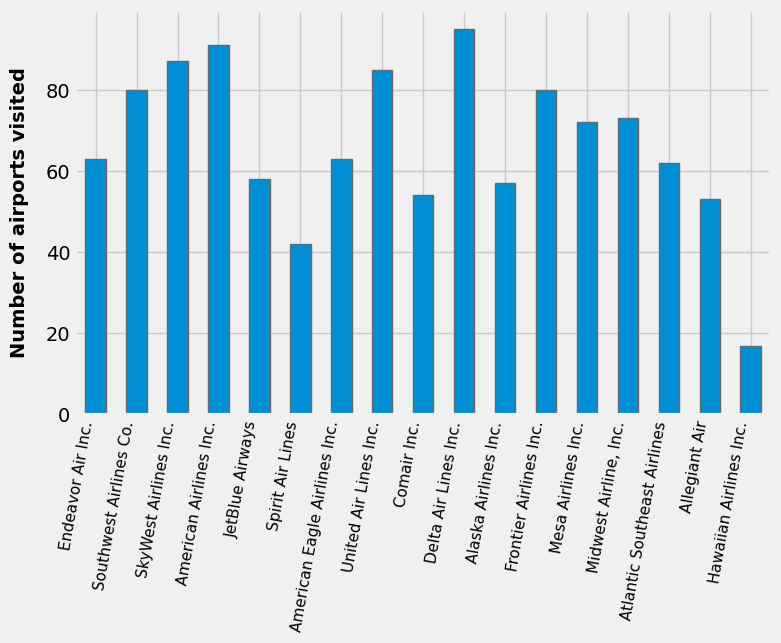

In [28]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,5))
labels = [company for company in companies]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

How the origin airport impact delays

Essayons de voir les variations des retards par rapport à l'aéroport d'origine et pour chaque compagnie aérienne. La première étape consiste donc à déterminer les retards moyens par aéroport.

In [29]:
# creons un dictionnaire de "DISPLAY_AIRPORT_NAME", pour facilement identifier la ville d'origine .
identify_airport = airports.set_index('DISPLAY_AIRPORT_NAME')['ORIGIN_CITY_NAME'].to_dict()

airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in companies:
    df1 = df[df['CARRIER_NAME'] == carrier]
    test = df1['DEP_DELAY_NEW'].groupby(df['ORIGIN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

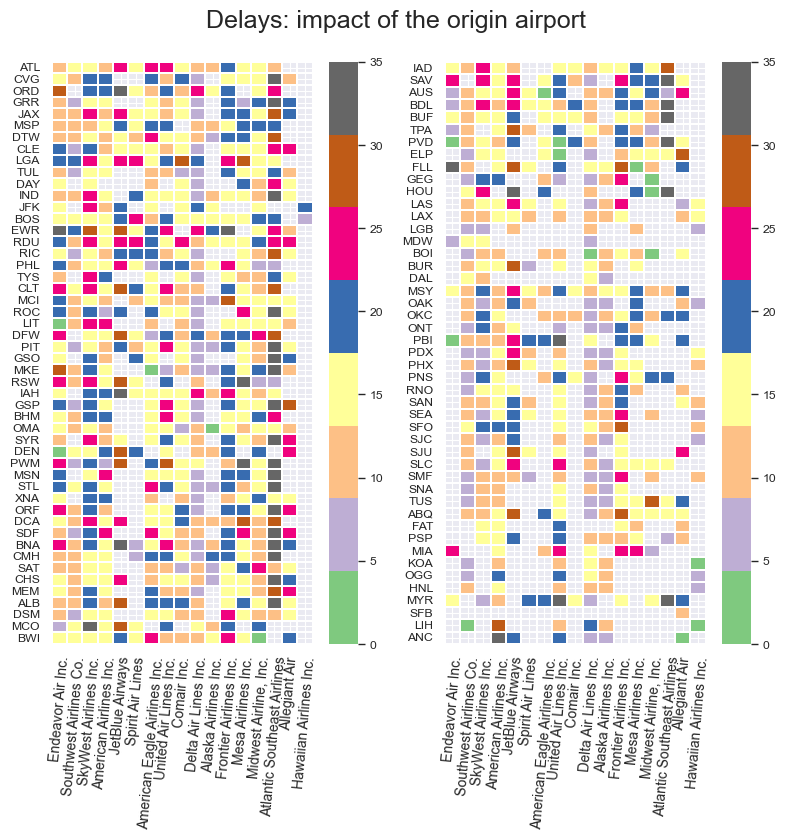

In [30]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:]
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85)
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:]
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85)
ax.yaxis.label.set_visible(False)

plt.tight_layout()

Comme on peut le constater, la ville a une grande influence sur les retards

# MODELISATION
    Avec toutes les données qu'on a à disposition, nous avons la capacité de predire s'il y'aura du retard d'un vol à l'arrivée ou depart, et ceci en fonction des differents parmètres une ville spécifique d'arrivéé ou de départ, une compagnie spécifique, un aéroport spécifique d'arrivée ou départ, le jour ou encore le mois de départ etc...
    mais nous n'allons pas trop nous étendre sur ces différentes optiions sinon cela créera un schema trop long, c'est pour cela qui nous allons prédire un retard ou nous sur les départs uniquements sur l'ensemble du jeu.

In [31]:
# 2. Feature engineering
cols_to_drop = ['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'TAIL_NUM' , 'DISTANCE_GROUP', 'CANCELLED', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME']
df = df.drop(cols_to_drop, axis=1)

df["DEP_DEL15"] = (df["DEP_DEL15"] > 0).astype(int)
print('Done...')

Done...


In [32]:
print(list(df.columns))

['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'ORIGIN_AIRPORT_NAME', 'CARRIER_NAME', 'DEP_DELAY', 'ARR_DELAY', 'DEP_ARR_DIFF']


In [33]:
# Vu le grand nombre de ligne , on va separer le dataset Sélectionner 10% des lignes au hasard afin que l'entrainement des models ne prenne pas beaucoup de temps

random_indices = np.random.choice(df.index, size=int(len(df)*0.1), replace=False)
sampled_df = df.loc[random_indices]

# Order by month
sampled_df = sampled_df.sort_values('MONTH')
sampled_df.head(1)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,ORIGIN_AIRPORT_NAME,CARRIER_NAME,DEP_DELAY,ARR_DELAY,DEP_ARR_DIFF
8332216,1,21,1,HA,48,HNL,OAK,870,880,10.0,0,1400-1459,1290,1315,25.0,2100-2159,300.0,315.0,2409.0,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",Hawaiian Airlines Inc.,1,1,-15.0


In [34]:
hgb

NameError: name 'hgb' is not defined

In [35]:
# Separate target variable Y from features X
print("Separating labels from features...")
X = sampled_df.drop(['DAY_OF_WEEK', 'DEP_DELAY_NEW', 'DEP_DEL15', 'ACTUAL_ELAPSED_TIME', 'DEP_TIME', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'DEP_ARR_DIFF', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN_AIRPORT_NAME'], axis=1)
y_classification = sampled_df['DEP_DEL15']
y_regression = sampled_df['DEP_DELAY_NEW']

print("...Done.")
print()

print('y classification : ')
print(y_classification.head())
print()
print('y regression : ')
print(y_regression.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

y classification : 
8332216    0
3599310    0
15674      1
4269955    0
576696     1
Name: DEP_DEL15, dtype: int32

y regression : 
8332216    10.000000
3599310     0.000000
15674      83.000000
4269955     1.000000
576696     14.307911
Name: DEP_DELAY_NEW, dtype: float64

X :
         MONTH  DAY_OF_MONTH OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST   
8332216      1            21                HA                 48    HNL  OAK  \
3599310      1            19                EV               4051    IAH  DSM   
15674        1            27                WN               2399    ATL  IND   
4269955      1            30                WN                323    STL  MCO   
576696       1            31                OO               5098    ORD  EAU   

         CRS_DEP_TIME  CRS_ARR_TIME  CRS_ELAPSED_TIME  DISTANCE   
8332216           870          1290             300.0    2409.0  \
3599310           585           727             142.0   

In [36]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []

for nom_colonne, dtype in X.dtypes.items():
    if ('float' in str(dtype)) or ('int' in str(dtype)):
        numeric_features.append(nom_colonne)
    else:
        categorical_features.append(nom_colonne)

print('numeric features detected : ', numeric_features)
print('categorical features détected : ', categorical_features)

numeric features detected :  ['MONTH', 'DAY_OF_MONTH', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE']
categorical features détected :  ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'CARRIER_NAME']


In [37]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42, stratify= y_classification)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



PREPROCESSING

In [38]:
# Create pipeline for numeric features

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
from sklearn.calibration import LabelEncoder

print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
encoder = LabelEncoder()
y_train_class = encoder.fit_transform(y_train_class)
print("...Done")

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Preparing labels...")
y_test_class = encoder.transform(y_test_class)
print("...Done")


Performing preprocessings on train set...
...Done.
  (0, 0)	0.1482510612990846
  (0, 1)	1.3972363280350184
  (0, 2)	-1.0435651144198383
  (0, 3)	-1.3187105348486312
  (0, 4)	-0.9389487335732465
  (0, 5)	0.573963880602385
  (0, 6)	0.5816117379668975
  (0, 11)	1.0
  (0, 116)	1.0
  (0, 167)	1.0
  (0, 479)	1.0
  (1, 0)	-0.8100810869965454
  (1, 1)	1.0551607501144113
  (1, 2)	-0.049449812257222246
  (1, 3)	-1.2280882684538221
  (1, 4)	-1.017987984393804
  (1, 5)	-0.13209590107298563
  (1, 6)	0.0412675944484008
  (1, 11)	1.0
  (1, 27)	1.0
  (1, 150)	1.0
  (1, 479)	1.0
  (2, 0)	-0.17119298813279202
  (2, 1)	-0.31314156156801737
  (2, 2)	0.5808954536652141
  :	:
  (2, 102)	1.0
  (2, 435)	1.0
  (2, 486)	1.0
  (3, 0)	1.1065832095947146
  (3, 1)	1.2832111353948161
  (3, 2)	0.8650907944778545
  (3, 3)	1.0475375321269413
  (3, 4)	1.1382027779910058
  (3, 5)	1.5515851167682828
  (3, 6)	1.4020729374811793
  (3, 21)	1.0
  (3, 73)	1.0
  (3, 407)	1.0
  (3, 487)	1.0
  (4, 0)	0.7871391601628379
  (4, 1)	0

A. TRAIN MODELS (LOGISTICREG, XGBOOSTCLASS, RFCLASS)

In [39]:
print(y_classification.value_counts(normalize=True))
0.794667/0.205333

DEP_DEL15
0    0.795495
1    0.204505
Name: proportion, dtype: float64


3.870137776197689

In [40]:
# Entraînement et évaluation des modèles de classification

lg_model = LogisticRegression(max_iter=1000, class_weight="balanced")
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=3.87)
rf_model = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

for model in [lg_model, xgb_model, rf_model]:
    model.fit(X_train, y_train_class)
    y_class_pred = model.predict(X_test)
    acc = accuracy_score(y_test_class, y_class_pred)
    print(f"{model.__class__.__name__} accuracy: {acc}")
    f1 = f1_score(y_test_class, y_class_pred)
    print(f"{model.__class__.__name__} F1-score: {f1}")
    precision = precision_score(y_test_class, y_class_pred)
    print(f"{model.__class__.__name__} Precision: {precision}")
    recall= recall_score(y_test_class, y_class_pred)
    print(f"{model.__class__.__name__} Recall: {recall}")
    print()

c:\Users\galus\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning:

`use_label_encoder` is deprecated in 1.7.0.



LogisticRegression accuracy: 0.6095446734887896
LogisticRegression F1-score: 0.39815050788218587
LogisticRegression Precision: 0.2907157572938127
LogisticRegression Recall: 0.6315363959229636

XGBClassifier accuracy: 0.6539849188962569
XGBClassifier F1-score: 0.4355264425392544
XGBClassifier Precision: 0.32678491406103183
XGBClassifier Recall: 0.6527300551497127



B. TRAIN MODELS (KNN, XGBOOSTREG, RFREG)

In [41]:
# Separate target variable Y from features X
print("Separating labels from features...")
X = sampled_df.drop(['DAY_OF_WEEK', 'DEP_DELAY_NEW', 'DEP_DEL15', 'ACTUAL_ELAPSED_TIME', 'DEP_TIME', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'DEP_ARR_DIFF', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN_AIRPORT_NAME'], axis=1)
y_classification = sampled_df['DEP_DEL15']
y_regression = sampled_df['DEP_DELAY_NEW']

print("...Done.")
print()

print('y classification : ')
print(y_classification.head())
print()
print('y regression : ')
print(y_regression.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

y classification : 
8332216    0
3599310    0
15674      1
4269955    0
576696     1
Name: DEP_DEL15, dtype: int32

y regression : 
8332216    10.000000
3599310     0.000000
15674      83.000000
4269955     1.000000
576696     14.307911
Name: DEP_DELAY_NEW, dtype: float64

X :
         MONTH  DAY_OF_MONTH OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST   
8332216      1            21                HA                 48    HNL  OAK  \
3599310      1            19                EV               4051    IAH  DSM   
15674        1            27                WN               2399    ATL  IND   
4269955      1            30                WN                323    STL  MCO   
576696       1            31                OO               5098    ORD  EAU   

         CRS_DEP_TIME  CRS_ARR_TIME  CRS_ELAPSED_TIME  DISTANCE   
8332216           870          1290             300.0    2409.0  \
3599310           585           727             142.0   

In [42]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.2, random_state=42)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [43]:
# Create pipeline for numeric features

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



# Preprocessings on train set
print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()

# Preprocessings on test set
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore

Performing preprocessings on train set...
...Done.
  (0, 0)	0.7879849393889908
  (0, 1)	0.484514604350506
  (0, 2)	0.3474479987512867
  (0, 3)	-1.4531172397103946
  (0, 4)	-0.5920376990660776
  (0, 5)	0.9794732328678899
  (0, 6)	1.1549267525133728
  (0, 11)	1.0
  (0, 102)	1.0
  (0, 352)	1.0
  (0, 479)	1.0
  (1, 0)	-1.1291870935939317
  (1, 1)	-0.8839672696142068
  (1, 2)	-1.0219714456209286
  (1, 3)	0.5949834523921098
  (1, 4)	1.656569147652737
  (1, 5)	1.5354568882651403
  (1, 6)	1.9214952984132574
  (1, 8)	1.0
  (1, 66)	1.0
  (1, 195)	1.0
  (1, 475)	1.0
  (2, 0)	-1.7682444379215727
  (2, 1)	-0.08568617646812439
  (2, 2)	-0.07566166346338446
  :	:
  (2, 78)	1.0
  (2, 214)	1.0
  (2, 487)	1.0
  (3, 0)	-0.4901297492662909
  (3, 1)	-0.5418468011230286
  (3, 2)	-0.1473173320642562
  (3, 3)	1.8842796257812273
  (3, 4)	-2.701490254286119
  (3, 5)	-0.39014504018387314
  (3, 6)	-0.25072485757086543
  (3, 8)	1.0
  (3, 39)	1.0
  (3, 396)	1.0
  (3, 475)	1.0
  (4, 0)	0.14892759506134998
  (4, 1)	0

In [45]:
# Entraînement et évaluation des modèles de régression
# Crée les modèles XGBoost, Random Forest et KNN
xgb_reg_model = xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse')
rf_reg_model = RandomForestRegressor(n_jobs=-1)
knn_reg_model = KNeighborsRegressor(n_neighbors=5)

# Boucle à travers les modèles et effectue l'entraînement et l'évaluation
for reg in [xgb_reg_model, rf_reg_model, knn_reg_model]:
    reg.fit(X_train, y_train_reg)  # Entraîne le modèle sur les données d'entraînement
    y_reg_pred = reg.predict(X_test)  # Fait des prédictions sur les données de test
    mse = mean_squared_error(y_test_reg, y_reg_pred)  # Calcule l'erreur quadratique moyenne
    rmse = np.sqrt(mse)  # Calcule la racine carrée de l'erreur quadratique moyenne pour obtenir le RMSE
    r2 = r2_score(y_test_reg, y_reg_pred)  # Calcule le score R2
    mae = mean_absolute_error(y_test_reg, y_reg_pred)  # Calcule l'erreur absolue moyenne
    explained_var = explained_variance_score(y_test_reg, y_reg_pred)  # Calcule le score de variance expliquée
   
    
    # Affiche les métriques d'évaluation pour chaque modèle
    print(f"{reg.__class__.__name__} RMSE: {rmse:.2f}")
    print(f"{reg.__class__.__name__} R2 Score: {r2:.2f}")
    print(f"{reg.__class__.__name__} MAE: {mae:.2f}")
    print(f"{reg.__class__.__name__} Explained Variance Score: {explained_var:.2f}")
    print()

XGBRegressor RMSE: 45.98
XGBRegressor R2 Score: 0.04
XGBRegressor MAE: 19.51
XGBRegressor Explained Variance Score: 0.04



Apès avoir entrainé ces 6 models, nous contastons que , ce soit pour la classification ou la regression, c'est XGBoost qui realise les meilleures performances.
Nous allons donc choisir ce model pour la suite de notre projet.

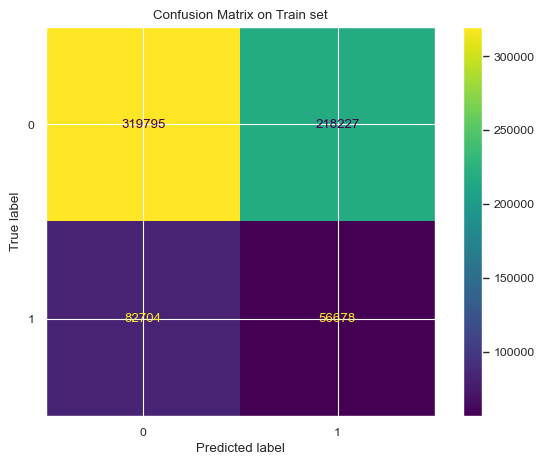

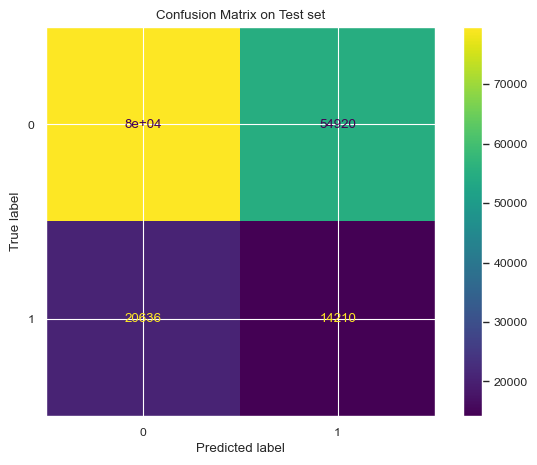

In [ ]:
# Visualize confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_model, X_train, y_train_class, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test_class, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

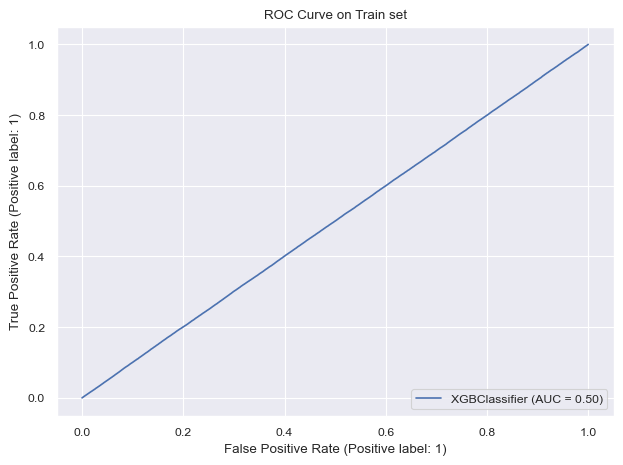

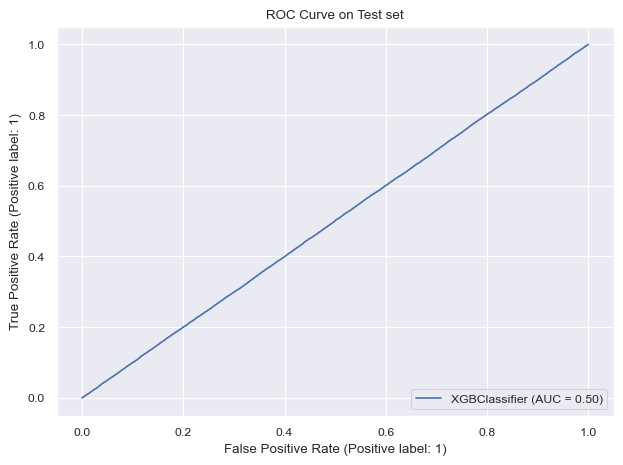

In [ ]:
# Visualize ROC curves
from sklearn.metrics import RocCurveDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(xgb_model, X_train, y_train_class, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(xgb_model, X_test, y_test_class, ax=ax) # RocCurveDisplay from sklearn
plt.show()

In [ ]:
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = xgb_model.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()


Names of columns corresponding to each coefficient:  ['MONTH', 'DAY_OF_MONTH', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6', 'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9', 'OP_UNIQUE_CARRIER_G4', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OH', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA', 'OP_UNIQUE_CARRIER_WN', 'OP_UNIQUE_CARRIER_YV', 'OP_UNIQUE_CARRIER_YX', 'ORIGIN_ABQ', 'ORIGIN_ALB', 'ORIGIN_ANC', 'ORIGIN_ATL', 'ORIGIN_AUS', 'ORIGIN_BDL', 'ORIGIN_BHM', 'ORIGIN_BNA', 'ORIGIN_BOI', 'ORIGIN_BOS', 'ORIGIN_BUF', 'ORIGIN_BUR', 'ORIGIN_BWI', 'ORIGIN_CHS', 'ORIGIN_CLE', 'ORIGIN_CLT', 'ORIGIN_CMH', 'ORIGIN_CVG', 'ORIGIN_DAL', 'ORIGIN_DAY', 'ORIGIN_DCA', 'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_DSM', 'ORIGIN_DTW', 'ORIGIN_ELP', 'ORIGIN_EWR', 'ORIGIN_FAT', 'ORIGIN_FLL', 'ORIGIN_GEG', 'ORIGIN_

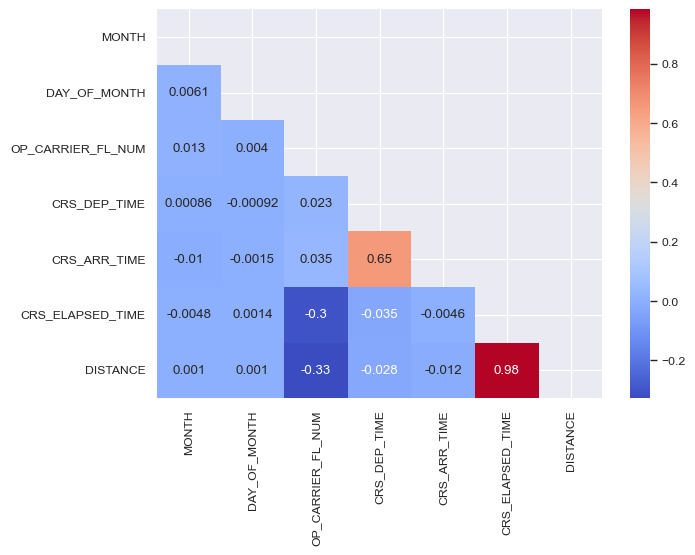

In [ ]:
# Supprimer les fonctionnalités qui ont une corrélation faible avec la variable cible ou qui ont des valeurs manquantes élevées
corr_matrix = df[numeric_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()



In [ ]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

Les résultats indiquent que notre modèle de régression logistique multiple est très performant. Le R2 score est proche de 1 sur les deux ensembles d'entraînement et de test, ce qui signifie que le modèle explique la grande majorité de la variance dans les données. La MAE (Mean Absolute Error) est relativement faible, ce qui indique que les prédictions du modèle sont en moyenne proches des valeurs réelles de la variable cible. De même, la RMSE (Root Mean Squared Error) est également faible, ce qui suggère que le modèle ne présente pas de grosses erreurs dans ses prédictions.

# DEPLOIEMENT DES MODELES SUR LE GRAND JEU DE DONNEES DF

1. Classification

In [74]:
# Separate target variable Y from features X
print("Separating labels from features...")
X = df.drop(['DAY_OF_WEEK', 'DEP_DELAY_NEW', 'DEP_DEL15', 'ACTUAL_ELAPSED_TIME', 'DEP_TIME', 'DEP_TIME_BLK', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'DEP_ARR_DIFF', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN_AIRPORT_NAME'], axis=1)
y_classification = df['DEP_DEL15']
y_regression = sampled_df['DEP_DELAY_NEW']

print("...Done.")
print()

Separating labels from features...
...Done.



In [75]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=0.2, random_state=42, stratify= y_classification)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [76]:
X.columns

Index(['MONTH', 'DAY_OF_MONTH', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM',
       'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME',
       'DISTANCE', 'CARRIER_NAME'],
      dtype='object')

Preprocessing

In [77]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []

for nom_colonne, dtype in X.dtypes.items():
    if ('float' in str(dtype)) or ('int' in str(dtype)):
        numeric_features.append(nom_colonne)
    else:
        categorical_features.append(nom_colonne)

print('numeric features detected : ', numeric_features)
print('categorical features détected : ', categorical_features)

numeric features detected :  ['MONTH', 'DAY_OF_MONTH', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE']
categorical features détected :  ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'CARRIER_NAME']


In [78]:
# Create pipeline for numeric features

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])



Train model

In [79]:
import pickle

preprocessor.fit(X_train)

with open("./ml_models/preprocessor.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

In [80]:
# Preprocessings on train set
from sklearn.calibration import LabelEncoder

print("Performing preprocessings on train set...")
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
encoder = LabelEncoder()
y_train_class = encoder.fit_transform(y_train_class)
print("...Done")

# Preprocessings on test set
print("Performing preprocessings on test set...")
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Preparing labels...")
y_test_class = encoder.transform(y_test_class)
print("...Done")

Performing preprocessings on train set...
...Done.
  (0, 0)	1.746453423673348
  (0, 1)	-1.225750397565703
  (0, 2)	-1.2518102688339405
  (0, 3)	-0.23521077548314204
  (0, 4)	-0.26950900854495485
  (0, 5)	-0.9323126730043697
  (0, 6)	-0.9890610960292715
  (0, 8)	1.0
  (0, 117)	1.0
  (0, 214)	1.0
  (0, 474)	1.0
  (1, 0)	1.746453423673348
  (1, 1)	0.9398052863871246
  (1, 2)	0.724500498675315
  (1, 3)	-0.06060539451095209
  (1, 4)	-0.03233763537820386
  (1, 5)	1.0037184875382383
  (1, 6)	0.8858781527991741
  (1, 21)	1.0
  (1, 114)	1.0
  (1, 304)	1.0
  (1, 486)	1.0
  (2, 0)	0.46790856003241454
  (2, 1)	-0.31393747800661764
  (2, 2)	0.6647846337577691
  :	:
  (2, 86)	1.0
  (2, 285)	1.0
  (2, 475)	1.0
  (3, 0)	-0.4910000876982856
  (3, 1)	-1.4537036274554742
  (3, 2)	0.23710529644353595
  (3, 3)	1.2791551248718132
  (3, 4)	1.1756552252844477
  (3, 5)	-0.8510805963382463
  (3, 6)	-1.076690531821077
  (3, 11)	1.0
  (3, 67)	1.0
  (3, 167)	1.0
  (3, 478)	1.0
  (4, 0)	1.746453423673348
  (4, 1)	0

In [51]:
# Entraînement et évaluation des modèles de classification

xgb_model.fit(X_train, y_train_class)
y_class_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test_class, y_class_pred)
print(f"Accuracy: {acc}")
f1 = f1_score(y_test_class, y_class_pred)
print(f"F1-score: {f1}")
precision = precision_score(y_test_class, y_class_pred)
print(f"Precision: {precision}")
recall= recall_score(y_test_class, y_class_pred)
print(f"Recall: {recall}")
print()

Accuracy: 0.6581313366912507
F1-score: 0.44267941441476133
Precision: 0.33311746826493743
Recall: 0.6596314167847656



In [52]:
X_test[5]

<1x489 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

Nous constatons qu'apres l'application du model sur le grand dataset, les metriques sont presque similaires, ce qui veut ce model s'est bien généralisé sur l'ensemble ded données.

2. Reg Lineaie multiple pour predire le temps de retard en cas de retard.

In [ ]:
# Filtrage des vols retardés pour la régression
# Sélectionne les données d'entraînement et de test pour lesquelles le vol a été retardé
X_train_reg = X_train[y_train_class == 1]
X_test_reg = X_test[y_test_class == 1]
y_reg_train = y_train_reg[y_train_class == 1]
y_reg_test = y_test_reg[y_test_class == 1]
print('Training model...')

# Entraînement et évaluation des modèles de régression
# Crée les modèles XGBoost, Random Forest et KNN
xgb_reg_model = xgb.XGBRegressor(use_label_encoder=False, eval_metric='rmse')


xgb_reg_model.fit(X_train_reg, y_reg_train)  # Entraîne le modèle sur les données d'entraînement
y_reg_pred = xgb_reg_model.predict(X_test_reg)  # Fait des prédictions sur les données de test
print('Done...')

mse = mean_squared_error(y_reg_test, y_reg_pred)  # Calcule l'erreur quadratique moyenne
rmse = np.sqrt(mse)  # Calcule la racine carrée de l'erreur quadratique moyenne pour obtenir le RMSE
r2 = r2_score(y_reg_test, y_reg_pred)  # Calcule le score R2
mae = mean_absolute_error(y_reg_test, y_reg_pred)  # Calcule l'erreur absolue moyenne
explained_var = explained_variance_score(y_reg_test, y_reg_pred)  # Calcule le score de variance expliquée
   
    
# Affiche les métriques d'évaluation du modèle
print(f"RMSE: {rmse:.2f}")
print()
print(f"R2 Score: {r2:.2f}")
print()
print(f"MAE: {mae:.2f}")
print()
print(f"Explained Variance Score: {explained_var:.2f}")

Training model...
Done...
RMSE: 83.50

R2 Score: 0.05

MAE: 46.63

Explained Variance Score: 0.05


Nous constatons qu'apres l'application du model de regression pour predire le temps de retard sur le grand dataset, les metriques sont egalement presque similaires que sur le petit jeu de données, ce qui veut que ce model s'est également bien généralisé sur l'ensemble de données.

# ENREGISTREMENT DE NOS MODELES

In [53]:
import pickle

# Enregistrer le modèle de classification avec Pickle

print('Saving model...')
with open('./ml_models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print('Model saved!...')


Saving model...
Model saved!...


In [63]:
X_train

<6774040x489 sparse matrix of type '<class 'numpy.float64'>'
	with 74514440 stored elements in Compressed Sparse Row format>

In [81]:
# Enregistrer le modèle de regresssion avec Pickle

print('Saving model...')
with open('./ml_models/xgb_reg_model.pkl', 'wb') as f:
    pickle.dump(xgb_reg_model, f)
print('Model saved!...')

Saving model...
Model saved!...


In [58]:
X.head(1)


,MONTH,DAY_OF_MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,CARRIER_NAME
0,1,6,9E,3280,ATL,CSG,1005,1052,47.0,83.0,Endeavor Air Inc.


In [57]:
print(X.dtypes)

MONTH                  int64
DAY_OF_MONTH           int64
OP_UNIQUE_CARRIER     object
OP_CARRIER_FL_NUM      int64
ORIGIN                object
DEST                  object
CRS_DEP_TIME           int64
CRS_ARR_TIME           int64
CRS_ELAPSED_TIME     float64
DISTANCE             float64
CARRIER_NAME          object
dtype: object
